### Question 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# helper function
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [4]:
# Download the dataset
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2025-04-16 02:17:20--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2025-04-16 02:17:21--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.01s   

2025-04-16 02:17:21 (250 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating

In [5]:
# loading training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

# transforming images by resizing them and transforming to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# initializing the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

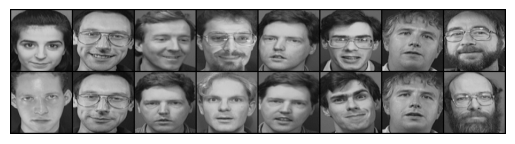

[1. 0. 1. 1. 0. 0. 0. 1.]


In [6]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [7]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [8]:
# Define the Contrastive Loss Function (evaluating the Siamese network)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [10]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 1.6860839128494263

Epoch number 1
 Current loss 1.4309418201446533

Epoch number 2
 Current loss 1.0084530115127563

Epoch number 3
 Current loss 0.9153600931167603

Epoch number 4
 Current loss 0.8918827772140503

Epoch number 5
 Current loss 0.685944676399231

Epoch number 6
 Current loss 0.5605676770210266

Epoch number 7
 Current loss 0.39215219020843506

Epoch number 8
 Current loss 0.3905569016933441

Epoch number 9
 Current loss 0.4151580035686493

Epoch number 10
 Current loss 0.4490666687488556

Epoch number 11
 Current loss 0.38015493750572205

Epoch number 12
 Current loss 0.4208352565765381

Epoch number 13
 Current loss 0.47088438272476196

Epoch number 14
 Current loss 0.42219120264053345

Epoch number 15
 Current loss 0.5158224105834961

Epoch number 16
 Current loss 0.30720657110214233

Epoch number 17
 Current loss 0.40817272663116455

Epoch number 18
 Current loss 0.3295680284500122

Epoch number 19
 Current loss 0.3522540330886841

Epoch

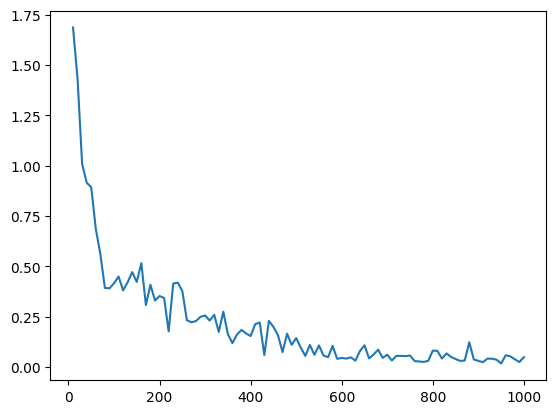

In [12]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

Based on the graph above, the loss is high at first because the model has random weights and therefore makes a lot of errors, since the model has not yet learned the distance features between similar and disimilar images. However, as the training progress, the loss is reduced and the model starts converging, which shows that the netowrk is reaching the optimal point for the training data. This reduction in loss and plateauing towards the end of the epochs indicates that the model has successfully learned from the training data, so the Siamese networks is able to effectively distinguish similar and disimilar images by the end of the training process.

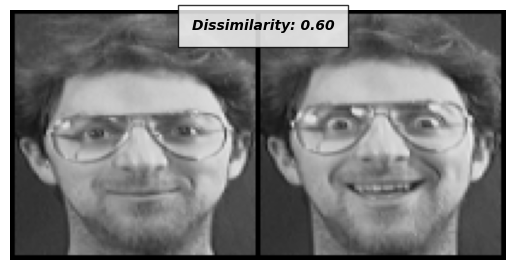

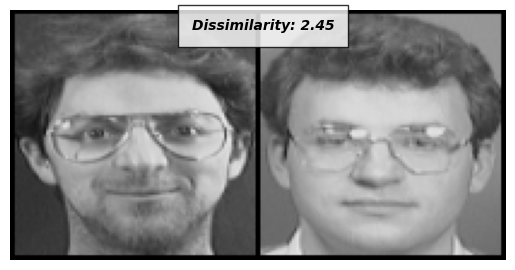

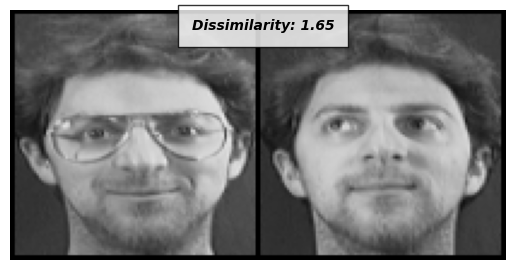

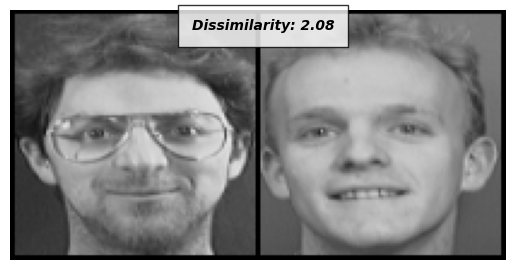

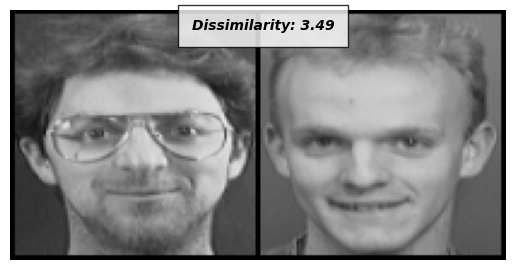

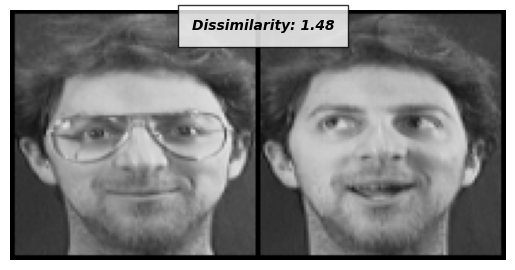

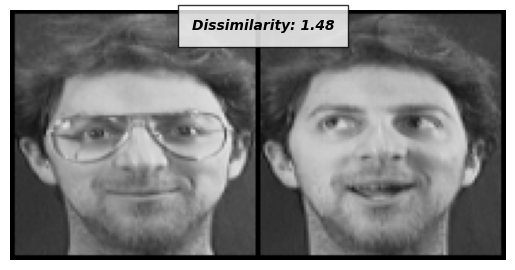

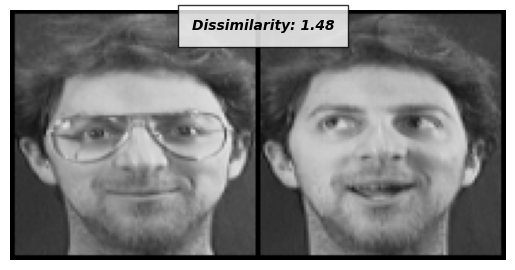

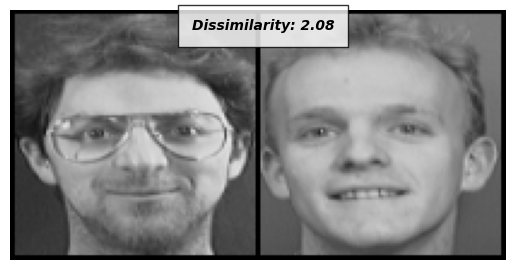

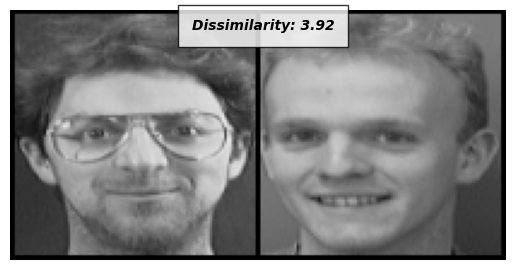

In [13]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    i, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

### Question 2

A range of candidate thresholds is generated, spanning from 0 up to the maximum observed distance.
For each threshold, predictions are made such that any distance above the threshold is classified as 1, and those below or equal to it are classified as 0.
The F1 score, which combines precision and recall into a single measure, is a good metric to use when dealing with imbalanced data. A higher F1 score reflects a better trade-off between precision and recall.
The optimal threshold is the one that yields the highest F1 score across the range.
When the dataset is imbalanced or when both types of errors (false positives and false negatives) matter, selecting the threshold that maximizes the F1 score helps ensure a more balanced and effective classification.

In [15]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch

def calculate_threshold(net, dataloader):
    net.eval()

    distances = []
    labels = []

    with torch.no_grad():
        for i, (img0, img1, label) in enumerate(dataloader):
            output1, output2 = net(img0.cuda(), img1.cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(label.cpu().numpy())

    distances = np.array(distances).flatten()
    labels = np.array(labels).flatten()

    thresholds = np.linspace(0, distances.max(), 1000)

    best_threshold = 0
    best_f1 = 0
    best_accuracy = 0
    for thresh in thresholds:
        predictions = (distances > thresh).astype(int)
        current_f1 = f1_score(labels, predictions)
        current_accuracy = accuracy_score(labels, predictions)
        if current_f1 >= best_f1:
            best_f1 = current_f1
            best_accuracy = current_accuracy
            best_threshold = thresh

    return best_threshold, best_accuracy

threshold, accuracy = calculate_threshold(net, train_dataloader)
print(f"Optimal threshold: {threshold:.2f}")
print(f"Highest accuracy: {accuracy:.2f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Optimal threshold: 1.13
Highest accuracy: 1.00


Using Euclidean distance to evaluate the similarity between feature vectors, the model reached 100% accuracy at a threshold of 1.13.
This indicates that the model was able to perfectly distinguish between same-person and different-person image pairs; all pairs belonging to the same person had distances below 1.13, while all pairs from different individuals had distances above this threshold.

### Question 3

In [16]:
from google.colab import files
uploaded = files.upload()

Saving MeGlass_120x120.zip to MeGlass_120x120.zip


In [20]:
!unzip -q MeGlass_120x120.zip -d ./MeGlass

In [21]:
!ls ./MeGlass

MeGlass_120x120


In [22]:
import os
import re
from collections import defaultdict
from PIL import Image

def build_glasses_dataset(path='./MeGlass/MeGlass_120x120', max_pairs=500):
    preprocess = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    grouped_images = defaultdict(lambda: {"glasses": [], "no_glasses": []})

    for filename in os.listdir(path):
        match = re.match(r'(.+_identity_\d+)@\d+_(\d)\.jpg$', filename)
        if match:
            person_id = match.group(1)
            label = int(match.group(2))  # 0: no glasses, 1: glasses
            file_path = os.path.join(path, filename)
            if label == 0:
                grouped_images[person_id]["no_glasses"].append(file_path)
            else:
                grouped_images[person_id]["glasses"].append(file_path)

    positive_samples, negative_samples = [], []
    all_ids = list(grouped_images.keys())

    for i, pid1 in enumerate(all_ids):
        images_1 = grouped_images[pid1]
        if images_1["glasses"] and images_1["no_glasses"]:
            # Positive example
            img_with = preprocess(Image.open(images_1["glasses"][0]))
            img_without = preprocess(Image.open(images_1["no_glasses"][0]))
            positive_samples.append((img_with, img_without, 0))

            # Negative example with a different identity
            for j in range(i + 1, len(all_ids)):
                images_2 = grouped_images[all_ids[j]]
                if images_2["glasses"]:
                    neg_example = preprocess(Image.open(images_2["glasses"][0]))
                    negative_samples.append((img_without, neg_example, 1))
                    break

        if len(positive_samples) >= max_pairs // 2 and len(negative_samples) >= max_pairs // 2:
            break

    return positive_samples + negative_samples

In [23]:
pairs = build_glasses_dataset(max_pairs=500)

In [28]:
sampled_pairs = build_glasses_dataset(max_pairs=500)
num_correct = 0
net.eval()

with torch.no_grad():
    for first_img, second_img, true_label in sampled_pairs:
        first_img = first_img.unsqueeze(0).cuda()
        second_img = second_img.unsqueeze(0).cuda()

        vec1, vec2 = net(first_img, second_img)
        dist = F.pairwise_distance(vec1, vec2).item()

        prediction = 0 if dist < threshold else 1
        num_correct += int(prediction == true_label)

final_accuracy = num_correct / len(sampled_pairs)
print(f"Classification accuracy on MeGlass: {final_accuracy:.2%}")

Classification accuracy on MeGlass: 51.00%


The model achieved an accuracy of 51% on the MeGlass dataset, indicating that it was only marginally better than random guessing when distinguishing between same-person and different-person image pairs under eyeglass variation. This suggests that the Siamese network trained on the original dataset (without glasses) struggled to generalize to the MeGlass dataset, which includes cross-domain differences such as occlusion from glasses. The difficulty arises because the model was not trained to account for significant appearance changes like the presence or absence of glasses. This result highlights the limitations of contrastive loss in cross-domain scenarios, where visual differences not present in training can drastically affect performance.

### Question 4

In [34]:
class MiningContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MiningContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate cosine similarity between pairs
        cos_sim = F.cosine_similarity(output1, output2)

        # Loss for similar (same identity) pairs
        same_loss = label * (1 - cos_sim)

        # Loss for dissimilar (different identity) pairs
        diff_loss = (1 - label) * F.relu(cos_sim - self.margin)

        # aggregate loss
        total_loss = same_loss + diff_loss
        return total_loss.mean()

In [35]:
net = SiameseNetwork().cuda()
criterion = MiningContrastiveLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# training loop
epochs = 100
for epoch in range(epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 1, Loss: 0.0037728857714682817
Epoch: 2, Loss: 9.266659617424011e-08
Epoch: 3, Loss: 1.8684659153223038e-08
Epoch: 4, Loss: 1.6996636986732483e-08
Epoch: 5, Loss: 1.257285475730896e-08
Epoch: 6, Loss: 7.697963155806065e-09
Epoch: 7, Loss: 1.4988472685217857e-08
Epoch: 8, Loss: 8.309143595397472e-09
Epoch: 9, Loss: 6.461050361394882e-09
Epoch: 10, Loss: 7.275957614183426e-09
Epoch: 11, Loss: 1.0826624929904938e-08
Epoch: 12, Loss: 4.6566128730773926e-09
Epoch: 13, Loss: 1.1175870895385742e-08
Epoch: 14, Loss: 7.450580596923828e-09
Epoch: 15, Loss: 8.41100700199604e-09
Epoch: 16, Loss: 4.3655745685100555e-09
Epoch: 17, Loss: 8.381903171539307e-09
Epoch: 18, Loss: 7.392372936010361e-09
Epoch: 19, Loss: 1.201988197863102e-08
Epoch: 20, Loss: 5.005858838558197e-09
Epoch: 21, Loss: 9.19681042432785e-09
Epoch: 22, Loss: 7.9016899690032e-09
Epoch: 23, Loss: 9.036739356815815e-09
Epoch: 24, Loss: 8.96397978067398e-09
Epoch: 25, Loss: 4.598405212163925e-09
Epoch: 26, Loss: 7.8580342233181

In [36]:
def calculate_threshold(net, loader):
    net.eval()
    cos_sims = []
    labels = []
    with torch.no_grad():
        for img0, img1, label in loader:
            img0, img1 = img0.cuda(), img1.cuda()
            output1, output2 = net(img0, img1)
            cos = F.cosine_similarity(output1, output2)
            cos_sims.extend(cos.cpu().numpy())
            labels.extend(label.cpu().numpy())

    labels = np.array(labels)
    cos_sims= np.array(cos_sims)

    # determing what the best threshold is
    best_accuracy = 0
    best_threshold = 0
    for threshold in np.linspace(0, 5, num=100):
        predictions = (cos_sims > threshold).astype(int)
        accuracy = accuracy_score(labels, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold, best_accuracy

threshold, accuracy = calculate_threshold(net, train_dataloader)
print(f"Best Threshold: {threshold}")
print(f"Best Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Best Threshold: 1.0101010101010102
Best Accuracy: 0.527027027027027


### Question 5

The model retrained using the Mining-Contrastive Loss achieved an accuracy of 52.27% on the MeGlass dataset. This is nearly identical to the performance obtained using the standard contrastive loss (which was 51.00%), indicating that the model still struggled to distinguish same-person and different-person image pairs under variation caused by eyeglasses.

This limited improvement suggests that while the mining strategy may help prioritize harder examples during training, it was not enough to overcome the challenges posed by domain shifts (e.g., occlusions from glasses). One possible reason is that most cosine similarities remained close to 1.0, suggesting that the model failed to learn sufficiently distinct embeddings. Other potential factors could include insufficient variation in the training data, low-dimensional embeddings, or overfitting to the training set.

Overall, while the accuracy is slightly higher, the result highlights the limitations of current methods when applied to datasets with substantial visual differences between training and testing conditions. Additional strategies such as higher-dimensional embeddings, more diverse training samples, and stronger hard-mining routines could potentially improve robustness in future work.